In [23]:
'''
!pip install opencv-python opencv-python-headless
!pip install tensorflow
!pip install keras
!pip install seaborn
!pip install scikit-learn
!pip install scikit-image
!pip install mahotas
!pip install scipy
'''

'\n!pip install opencv-python opencv-python-headless\n!pip install tensorflow\n!pip install keras\n!pip install seaborn\n!pip install scikit-learn\n!pip install scikit-image\n!pip install mahotas\n!pip install scipy\n'

In [24]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from keras import preprocessing, utils, models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,  Dense
import mahotas as mh
import scipy.stats
from skimage import io, color, util, filters, measure

In [25]:
dataset = []
label = []
input_size = 64
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Add picture to correct array for both testing and training data
for each in labels:
    training_data_path = 'data/Training/' + each
    for pic in os.listdir(training_data_path):
        img = cv2.imread(os.path.join(training_data_path, pic))
        img = cv2.resize(img, (input_size, input_size))
        dataset.append(np.array(img))
        label.append(each)

for each in labels:
    testing_data_path = 'data/Testing/' + each
    for pic in os.listdir(testing_data_path):
        img = cv2.imread(os.path.join(testing_data_path, pic))
        img = cv2.resize(img, (input_size, input_size))
        dataset.append(np.array(img))
        label.append(each)

dataset = np.array(dataset)
label = np.array(label)

#Set test_size to .3 as a standard and keep the random_state (seed) to 100 for reproducability
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.3, random_state=100)

y_train_numerical = []
for label_cat in y_train:
    numerical_label = labels.index(label_cat)
    y_train_numerical.append(numerical_label)

y_train = tf.keras.utils.to_categorical(y_train_numerical)

y_test_numerical = []
for label_cat in y_test:
    numerical_label = labels.index(label_cat)
    y_test_numerical.append(numerical_label)

y_test = tf.keras.utils.to_categorical(y_test_numerical)


In [ ]:
#Create the model and run it on the testing data

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(input_size, input_size, 3)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, verbose=2)

In [ ]:
#evaluate model

model_evaluation=model.evaluate(x_train, y_train)
print(model_evaluation)

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9925 - loss: 0.0312
[0.10115595161914825, 0.9737303256988525]


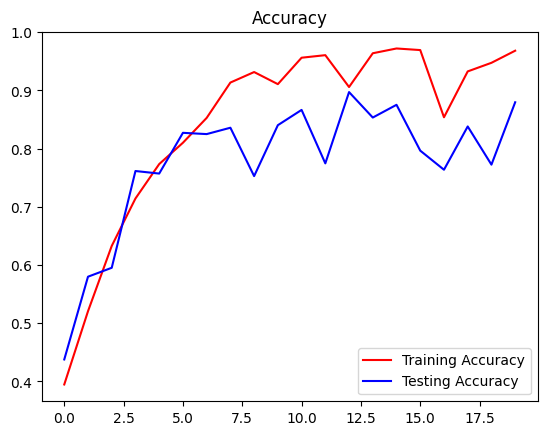

In [ ]:
#Graph the model's accuracy

training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']
epochs = range(len(training_accuracy))
fig = plt.figure()
plt.title('Accuracy')
plt.plot(epochs,training_accuracy,'r',label="Training Accuracy")
plt.plot(epochs,testing_accuracy,'b',label="Testing Accuracy")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Load example images
mri_image = cv2.imread('data/Training/pituitary_tumor/p (41).jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('data/Training/pituitary_tumor/p (41).jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('data/Training/pituitary_tumor/p (41).jpg')
img = cv2.resize(img, (64, 64))
img_array = img.reshape(1, 64, 64, 3)

In [ ]:
# Predict tumor classification
tdc=model.predict(img_array)
indices = tdc.argmax()
type = indices
if indices==0:
    type = "Glioma Tumour"
elif indices==1:
    type = "Meningioma Tumour"
elif indices==2:
    type = "Healthy Brain"
else:
    type = "Pituitary Tumour"

_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
highlighted = cv2.addWeighted(mri_image, 0.7, binary_mask, 0.3, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


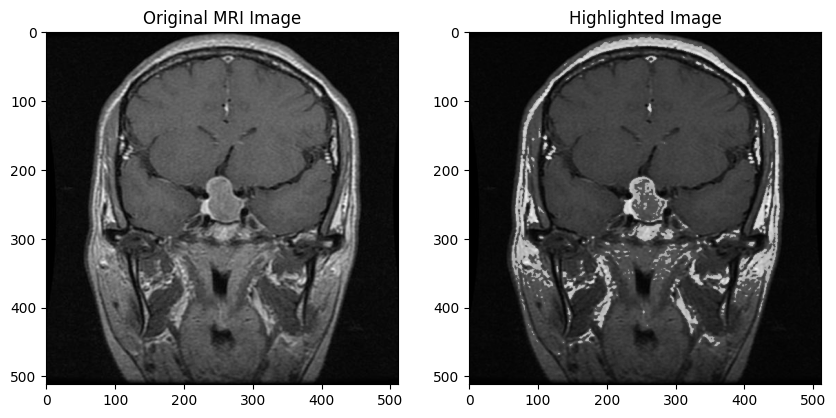

Classification: Pituitary Tumour


Mean: 53.82262420654297
Standard Deviation: 53.01537367704268
Entropy: 4.572199674360572
RMS: 7.771255877122748
Variance: 2810.6298461164697
Smoothness: 0.9996443344057607
Kurtosis: -0.9018476649186504
Skewness: 0.36651176762763893
Contrast: [185.26765075 285.93691813 164.36701168 287.33758679]
Correlation: [0.9670395  0.94912603 0.97075788 0.94887682]
Energy: [0.56663092 0.52496798 0.56046676 0.5244588 ]
Homogeneity: [7.32482675 7.60955046 7.28430063 7.60568785]


In [ ]:
# Plot brain scans
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mri_image, cmap='gray')
plt.title('Original MRI Image')
plt.subplot(1, 2, 2)
plt.imshow(highlighted, cmap='gray')
plt.title('Highlighted Image')
plt.show()

mask = mask > filters.threshold_otsu(mask)
tumor_region= np.where(mask, mri_image, 0)

# Calculating the features
mean = np.mean(tumor_region)
std_dev = np.std(tumor_region)
entropy = measure.shannon_entropy(tumor_region)
rms = np.sqrt(np.mean(tumor_region**2))
variance = np.var(tumor_region)
smoothness = 1 - 1 / (1 + variance)
kurtosis = scipy.stats.kurtosis(tumor_region.flatten())
skewness = scipy.stats.skew(tumor_region.flatten())
haralick_features = mh.features.haralick(tumor_region.astype(int))
contrast = haralick_features[:, 1]
correlation = haralick_features[:, 2]
energy = haralick_features[:, 4]
homogeneity = haralick_features[:, 8]

# Print classification and features
print(f'Classification: {type}\n\n')
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Entropy: {entropy}")
print(f"RMS: {rms}")
print(f"Variance: {variance}")
print(f"Smoothness: {smoothness}")
print(f"Kurtosis: {kurtosis}")
print(f"Skewness: {skewness}")
print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")
print(f"Energy: {energy}")
print(f"Homogeneity: {homogeneity}")